In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from joblib import dump, load
import azureml.core
from azureml.core import Experiment, Workspace, Dataset, Datastore, ScriptRunConfig
from azure.storage.fileshare import ShareFileClient
from os.path import join
import matplotlib
import matplotlib.pyplot as plt
import glob
import fiona
import shapely
import gdal
import osr
import sys

sys.path.append('/home/azureuser/cloudfiles/code/Users/LSalih/landcover_prog')
import numpy as np
import os
from os import path as op
import rasterio
from DataLoader import DataLoaderCustom, InMemoryRaster, warp_data_to_3857, crop_data_by_geometry
from Utils import setup_logging, get_random_string, class_prediction_to_img
from ModelSessionKerasExample import KerasDenseFineTune
from Models import _load_model, load_models
from Datasets import load_datasets
import numpy
import tensorflow as tf
from tensorflow import keras
import sklearn
import json
import cv2

from ModelSessionAbstract import ModelSession


In [2]:

# load workspace configuration from the config.json file in the current folder.
ws = Workspace.from_config()
    

# get metadata about the workspace
print(ws.name, ws.location, ws.resource_group, sep='\t')
# list the registered datastores
print(ws.datastores)

change-detection	eastus2	place
{'place': {
  "name": "place",
  "container_name": "landcover-ai",
  "account_name": "changedetectio8527471924",
  "protocol": "https",
  "endpoint": "core.windows.net"
}, 'cddatafilestore': {
  "name": "cddatafilestore",
  "container_name": "my-share",
  "account_name": "changedetectio8527471924",
  "protocol": "https",
  "endpoint": "core.windows.net"
}, 'azureml_globaldatasets': {
  "name": "azureml_globaldatasets",
  "container_name": "globaldatasets",
  "account_name": "mmstorageeastus2",
  "protocol": "https",
  "endpoint": "core.windows.net"
}, 'workspacefilestore': {
  "name": "workspacefilestore",
  "container_name": "azureml-filestore-06b1acca-db8a-4803-b66e-c72b2b4f0327",
  "account_name": "changedetectio8527471924",
  "protocol": "https",
  "endpoint": "core.windows.net"
}, 'workspaceblobstore': {
  "name": "workspaceblobstore",
  "container_name": "azureml-blobstore-06b1acca-db8a-4803-b66e-c72b2b4f0327",
  "account_name": "changedetectio85274

In [3]:
# register our data share containing image data
Datastore.register_azure_file_share(
    account_key = 'Dku+0TqE3wzDk0vpS72stllllxRpWbSqK0qjDblVX3pSha2Qhiq2/E8wW15KcuSThZ24WGmttkSNjgIGdkBzDA==',
    workspace = ws,
    datastore_name = 'place',
    file_share_name = 'landcover-ai',
    account_name = 'changedetectio8527471924')

{
  "name": "place",
  "container_name": "landcover-ai",
  "account_name": "changedetectio8527471924",
  "protocol": "https",
  "endpoint": "core.windows.net"
}

In [ ]:
Dku+0TqE3wzDk0vpS72stllllxRpWbSqK0qjDblVX3pSha2Qhiq2/E8wW15KcuSThZ24WGmttkSNjgIGdkBzDA== 
Workspace.create(name='change-detection', subscription_id='c394ca90-7d39-44ca-902d-a857ca6258cf', resource_group='place') 
'place '
'landcover-ai '
'changedetectio8527471924'

In [4]:
# access the datashare with model checkpoint and imagery
datastore = Datastore.get(workspace = ws, datastore_name = 'place')

#
travis_path = (datastore, 'travis_test/')
mecklenburg_path = (datastore, 'mecklenburg_county/')

In [5]:
travis_county = Dataset.File.from_files(path = [travis_path])

In [6]:
test_mount = travis_county.mount()

In [7]:
test_mount.start()

In [8]:
dataset_mount_folder = test_mount.mount_point


In [10]:
print(dataset_mount_folder)

/tmp/tmp4zk2tmhu


In [9]:
test_files = []
for root, dirs, files in os.walk(dataset_mount_folder):
    for f in files:
        test_files.append(join(root, f))

print(test_files)

['/tmp/tmp4zk2tmhu/travis_2016_UL-0000000000-0000000000.tif', '/tmp/tmp4zk2tmhu/travis_2016_UL-0000000000-0000011776.tif']


In [52]:
geom_t2016_UL = {
  "type": "Polygon",
  "coordinates": [[[-98.93314412259393,30.542412676693445],[-98.86447957181268,30.542412676693445],[-98.86447957181268,30.601532227903597],[-98.93314412259393,30.601532227903597],[-98.93314412259393,30.542412676693445]]]
}



In [53]:
def get_data_from_geometry(image_path, geometry):
    #TODO: Figure out what happens if we call this with a geometry that doesn't intersect the data source.
    f = rasterio.open(image_path, "r")
    src_profile = f.profile
    src_crs = f.crs.to_string()
    transformed_mask_geom = fiona.transform.transform_geom("epsg:4326", src_crs, geometry)
    src_image, src_transform = rasterio.mask.mask(f, [transformed_mask_geom], crop=True, all_touched=True, pad=False)
    f.close()
    print(src_image.shape)
    src_image = np.rollaxis(src_image, 0, 3)
    print(src_image.shape)
    return InMemoryRaster(src_image, src_crs, src_transform, shapely.geometry.shape(transformed_mask_geom).bounds)


In [54]:
input_raster = get_data_from_geometry(test_files[0], geom_t2016_UL)


Downloaded path: /tmp/tmp04avvvav/63f7116e-4f51-4c89-b3fa-68ea264312c4/travis_test/travis_2016_UL-0000000000-0000000000.tif is different from target path: /tmp/tmp04avvvav/63f7116e-4f51-4c89-b3fa-68ea264312c4/travis_2016_UL-0000000000-0000000000.tif
(4, 765, 765)
(765, 765, 4)


In [55]:
def pred_tile(input_raster):
    test = KerasDenseFineTune()
    output = test.run(input_raster.data, True)
    assert input_raster.shape[0] == output.shape[0] and input_raster.shape[1] == output.shape[1], "ModelSession must return an np.ndarray with the same height and width as the input"

    return InMemoryRaster(output, input_raster.crs, input_raster.transform, input_raster.bounds)


In [56]:
output_raster = pred_tile(input_raster)

(765, 765, 10)
(765, 765, 64)


In [57]:
output_raster.shape

(765, 765, 5)

In [58]:
def load_classes_json():
    classes = json.load(open( "classes.json","r"))
    return classes

classes_json = load_classes_json()

class_list = []
color_list = []

for i in range(len(classes_json)):
    class_list.append(classes_json[i]['name'])

for i in range(len(classes_json)):
    color_list.append(classes_json[i]['color'])



In [59]:
output_raster.shape

(765, 765, 5)

In [60]:
# Everything below here is from landcover's server.py document
# returning the index with the maximum value in respect to both axes 
output_hard = output_raster.data.argmax(axis=2)
nodata_mask = np.sum(input_raster.data == 0, axis=2) == input_raster.shape[2]
output_hard[nodata_mask] = 255
class_vals, class_counts = np.unique(output_hard[~nodata_mask], return_counts=True)
img_hard = class_prediction_to_img(output_raster.data, True, color_list)
img_hard = cv2.cvtColor(img_hard, cv2.COLOR_RGB2BGRA)
img_hard[nodata_mask] = [0,0,0,0]
output_raster.data = img_hard
output_raster.shape = img_hard.shape
warped_output_raster = warp_data_to_3857(output_raster) # warp output to 3857
cropped_warped_output_raster = crop_data_by_geometry(warped_output_raster, geom_t2016_UL, "epsg:4326") # crop to the desired shape
img_hard = cropped_warped_output_raster.data


In [61]:
output_hard.shape

(765, 765)

In [62]:
tmp_id = get_random_string(8)
new_profile = {}
new_profile['driver'] = 'GTiff'
new_profile['dtype'] = 'uint8'
new_profile['compress'] = "lzw"
new_profile['count'] = 1
new_profile['transform'] = output_raster.transform
new_profile['height'] = output_hard.shape[0] 
new_profile['width'] = output_hard.shape[1]
new_profile['crs'] = output_raster.crs
with rasterio.open("t%s.tif" % (tmp_id), 'w', **new_profile) as f:
    f.write(output_hard.astype(np.uint8), 1)



In [63]:
print(color_list)

['#0000FF', '#008000', '#80FF80', '#806060', '#816BD0', '#A9DEF1']


(1, 765, 765)


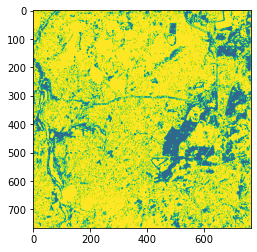

In [66]:
img = rasterio.open('tbeissgvw.tif')

print(img.read().shape)

###create color key for classes

plt.imshow(img.read(1))